# **Timeseries of Control Run Metrics**

**Important metrics:**

- SH sea ice extent/volume
- regional sea ice extent/volume
- regional NPP, PCO2, SSS, SST
- gridpoint-level fields for sea ice concentration, SST, SSS, NPP, PCO2
- sea ice edge position (latitude at which sea ice concentration drops below 15%)

In [1]:
import os
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range")
warnings.filterwarnings("ignore", message="invalid value encountered in reduce")

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

### Functions

In [2]:
## return the size of the dataset in gigabytes GB (not gibibytes GiB)
def size(da):
    return str(da.nbytes / (1000**3))+' gigabytes'

## view contents of a directory
def inspect(path):
    return sorted(os.listdir(path))

In [3]:
def open_ctrl_ds(var, metric):
    write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
    subdir_ctrl = 'CTRL/'
    filename = write_rootdir+subdir_ctrl+var.upper()+'/'+var.lower()+'_ctrl_so_'+metric+'.nc'
    return xr.open_dataset(filename)

### Import data (raw)

In [4]:
rootdir = '/local/projects/so_predict/esm2m_froelicher/'
subdir_ctrl = 'CTRL/'
subdir_grid = 'GRID/'

inspect(rootdir+subdir_ctrl)

['CN', 'EXT', 'HI', 'MLD', 'NPP', 'PCO2SURF', 'SSS', 'SST']

In [5]:
ocean_grid = xr.open_dataset(rootdir+subdir_grid+'ocean.static.nc')

geolat_t = ocean_grid.geolat_t
geolon_t = ocean_grid.geolon_t

In [6]:
path_sst = rootdir+subdir_ctrl+'/SST/sst_*.nc'
ds_sst = xr.open_mfdataset(path_sst)

In [7]:
path_sss = rootdir+subdir_ctrl+'/SSS/sss_*.nc'
ds_sss = xr.open_mfdataset(path_sss)

## add geolon_t and geolat_t coordinates
ds_sss = ds_sss.assign_coords({'geolon_t':geolon_t, 'geolat_t':geolat_t})

In [8]:
path_cn = rootdir+subdir_ctrl+'/CN/CN_inv_*.nc'
var_cn = 'CN_INV'

ds_cn = xr.open_mfdataset(path_cn)

## change XT / YT to ocean model grid coordinates xt_ocean / yt_ocean
ds_cn = ds_cn.rename({'XT':'xt_ocean', 'YT':'yt_ocean', 'TIME':'time'})
ds_cn = ds_cn.assign_coords({'xt_ocean':ocean_grid.xt_ocean, 'yt_ocean':ocean_grid.yt_ocean})

## add geolon_t and geolat_t coordinates
ds_cn = ds_cn.assign_coords({'geolon_t':geolon_t, 'geolat_t':geolat_t})

In [9]:
path_npp = rootdir+subdir_ctrl+'/NPP/NPP_*.nc'
var_npp = 'NPP'

ds_npp = xr.open_mfdataset(path_npp)

## rename coordinates for continuity
ds_npp = ds_npp.rename({'XT_OCEAN':'xt_ocean', 'YT_OCEAN':'yt_ocean', 'TIME':'time'})

## add geolon_t and geolat_t coordinates
ds_npp = ds_npp.assign_coords({'geolon_t':geolon_t, 'geolat_t':geolat_t})

In [10]:
path_pco2surf = rootdir+subdir_ctrl+'/PCO2SURF/pco2surf_*.nc'
var_pco2surf = 'pco2surf'

ds_pco2surf = xr.open_mfdataset(path_pco2surf)

### Import data (processed)

In [11]:
write_rootdir = '/home/bbuchovecky/storage/so_predict_derived/'
subdir_ctrl = 'CTRL/'

inspect(write_rootdir+subdir_ctrl)

['CN_INV', 'NPP', 'PCO2SURF', 'SIE', 'SIV', 'SI_EDGE', 'SSS', 'SST']

In [12]:
## variable names
CN_INV = 'CN_INV'
NPP = 'NPP'
PCO2SURF = 'PCO2SURF'
SIE = 'SIE'
SIV = 'SIV'
SI_EDGE = 'SI_EDGE'
SSS = 'SSS'
SST = 'SST'

In [64]:
clim = 'climatology'
anom = 'anomaly'
var = 'variance'

sst_clim = open_ctrl_ds(SST, clim) 
sst_anom = open_ctrl_ds(SST, anom)
sst_variance = open_ctrl_ds(SST, var)

sss_clim = open_ctrl_ds(SSS, clim) 
sss_anom = open_ctrl_ds(SSS, anom)
sss_variance = open_ctrl_ds(SSS, var)

cn_clim = open_ctrl_ds(CN_INV, clim) 
cn_anom = open_ctrl_ds(CN_INV, anom)
cn_variance = open_ctrl_ds(CN_INV, var)

npp_clim = open_ctrl_ds(NPP, clim) 
npp_anom = open_ctrl_ds(NPP, anom)
npp_variance = open_ctrl_ds(NPP, var)

pco2surf_clim = open_ctrl_ds(PCO2SURF, clim)
pco2surf_anom = open_ctrl_ds(PCO2SURF, anom)
pco2surf_var = open_ctrl_ds(PCO2SURF, var)

sie_path = write_rootdir+subdir_ctrl+SIE+'/'+'sie_ctrl_so_timeseries.nc'
sie_metrics = xr.open_dataset(sie_path)

siv_path = write_rootdir+subdir_ctrl+SIV+'/'+'siv_ctrl_so_timeseries.nc'
siv_metrics = xr.open_dataset(siv_path)

## SI_EDGE

In [65]:
reg_masks = xr.open_dataset(write_rootdir+'regional_global_masks.nc')

In [67]:
sss_anom

<xarray.Dataset>
Dimensions:   (time: 3600, xt_ocean: 360, yt_ocean: 42)
Coordinates:
  * time      (time) object 0001-01-16 12:00:00 ... 0300-12-16 12:00:00
  * yt_ocean  (yt_ocean) float64 -81.5 -80.5 -79.5 -78.5 ... -42.5 -41.5 -40.5
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
    geolat_t  (yt_ocean, xt_ocean) float32 ...
    geolon_t  (yt_ocean, xt_ocean) float32 ...
    month     (time) int64 ...
Data variables:
    sst_anom  (time, yt_ocean, xt_ocean) float32 ...

# Analysis

In [54]:
v = 'sst'
sst_raw_t = ds_sst[v].mean(dim={'xt_ocean', 'yt_ocean'})
sst_anom_t = sst_anom[v+'_anom'].mean(dim={'xt_ocean', 'yt_ocean'})
sst_variance_t = sst_variance[v+'_variance'].mean(dim={'xt_ocean', 'yt_ocean'})

In [55]:
v = 'sss'
sss_raw_t = ds_sss[v].mean(dim={'xt_ocean', 'yt_ocean'})
sss_anom_t = sss_anom[v+'_anom'].mean(dim={'xt_ocean', 'yt_ocean'})
sss_variance_t = sss_variance[v+'_variance'].mean(dim={'xt_ocean', 'yt_ocean'})

KeyError: 'sss_anom'

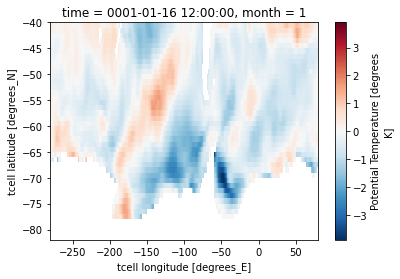

In [56]:
sss_anom.sst_anom[0].plot()

In [63]:
sss_anom

<xarray.Dataset>
Dimensions:   (time: 3600, xt_ocean: 360, yt_ocean: 42)
Coordinates:
  * time      (time) object 0001-01-16 12:00:00 ... 0300-12-16 12:00:00
  * yt_ocean  (yt_ocean) float64 -81.5 -80.5 -79.5 -78.5 ... -42.5 -41.5 -40.5
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
    geolat_t  (yt_ocean, xt_ocean) float32 -81.5 -81.5 -81.5 ... -40.5 -40.5
    geolon_t  (yt_ocean, xt_ocean) float32 -279.5 -278.5 -277.5 ... 78.5 79.5
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst_anom  (time, yt_ocean, xt_ocean) float32 ...